<a href="https://colab.research.google.com/github/Onyimatics/nlp_tweets_classification/blob/master/Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install emoji
!pip install contractions
!pip install wordsegment
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
# from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# libraries for data preprocessing
import nltk

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import emoji
import spacy
import contractions
import html
import demoji

# libraries for data split and feature extraction
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# library for evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# libraries for ML algorithms
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

# download modules available with NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('words')
# Load spaCy model
# nlp = spacy.load("en_core_web_sm")

RANDOM_SEED = 100
# stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
# Reading the train and test dataset
tweet_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1KplvwpbpA-Mi3QB3xy5myvmmYuq6fRnp')
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1VvLBWXH_ZVVVl-Y6dod-gXMAUWkrT03C')

In [ ]:
print(tweet_df.shape)
tweet_df.head()

(13240, 3)


,id,tweet,label
0,86426,@USER She should ask a few native Americans wh...,UNT
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
2,16820,Amazon is investigating Chinese employees who ...,NOT
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [ ]:
# drop the rows where at least one element is missing
tweet_df = tweet_df.dropna()

print(f'Number of entries: {len(tweet_df)}')

Number of entries: 13240


##EDA

<ipython-input-6-312142616b07>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=label_df.index, y='Count', data=label_df, palette=palette)


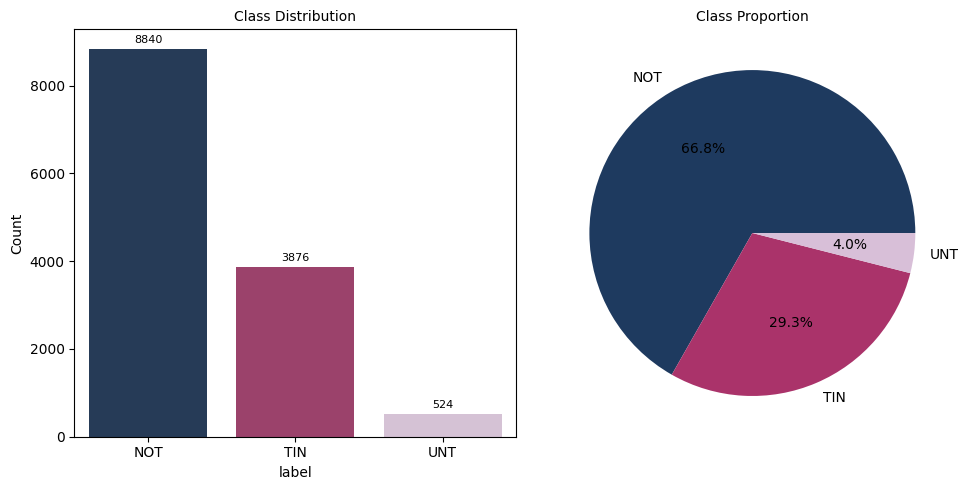

In [ ]:
# Summarise class details
# sns.countplot(x=tweet_df['label'])

# Define custom color palette for consistency
palette = ['#1e3a5f', '#AA336A', '#D8BFD8']

# Create a DataFrame to hold label counts and percentages
label_df = tweet_df['label'].value_counts().to_frame(name='Count')
label_df['Percentage'] = (label_df['Count'] / tweet_df.shape[0] * 100).round(2)

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# ---- Left Plot: Bar Plot for Class Distribution ----
plt.subplot(121)
bars = sns.barplot(x=label_df.index, y='Count', data=label_df, palette=palette)
for b in bars.patches:
    x = b.get_x() + (b.get_width() / 2)
    y = b.get_height()
    bars.annotate(f'{int(y)}', xy=(x, y), ha='center', va='center', size=8, xytext=(0, 6), textcoords='offset points')
plt.title('Class Distribution', fontsize=10)

# ---- Right Plot: Pie Chart for Class Proportion ----
plt.subplot(122)
plt.pie(label_df['Percentage'], labels=label_df.index, autopct='%1.1f%%', colors=palette)
plt.title('Class Proportion', fontsize=10)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

<ipython-input-7-ce4484613237>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_data.index, y=grouped_data.values, palette=palette)


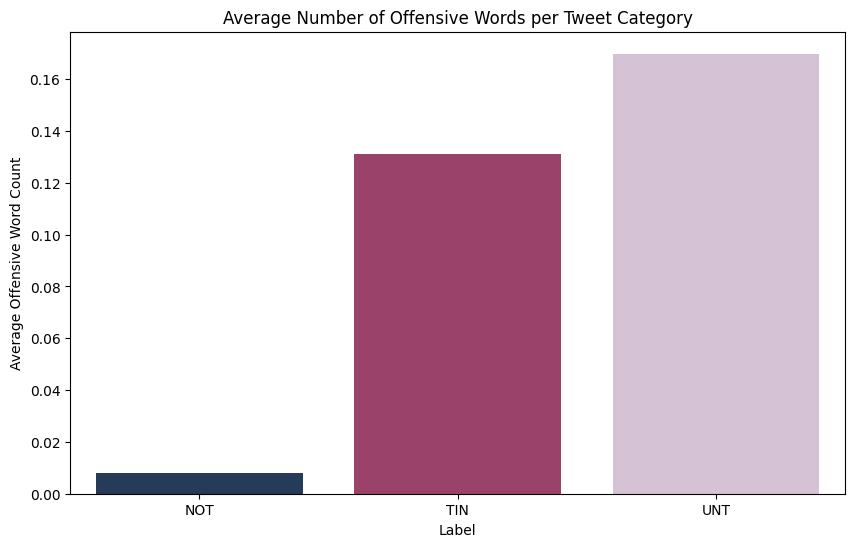

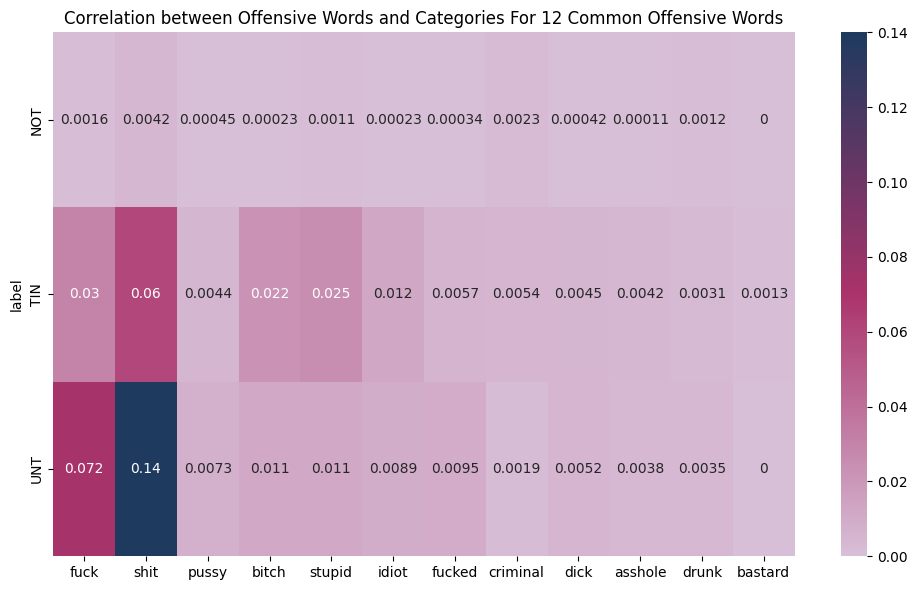

In [ ]:
# Explicit Offensive Word Frequency Analysis (with array)
offensive_words = [
    "fuck", "shit", "pussy", "bitch", "stupid", "idiot", "fucked", "criminal", "dick",#Add more words
     "asshole", "drunk", "bastard", "slut", "cuck", "cunt", "faggot", #Expanded list
    "whore", "twat", "motherfucker", "douchebag", "retard", "slut", "skank", "f***ing", "f**ked", "F*******" "B******"  #Further expansion
]

def count_offensive_words(text):
    words = text.split()
    count = sum([1 for word in words if word in offensive_words])
    return count

tweet_df['offensive_word_count'] = tweet_df['tweet'].apply(count_offensive_words)

import matplotlib.colors as mcolors

# plt.figure(figsize=(20, 5))
# # Bar Chart of Average Offensive Word Count by Category
colors = ['#D8BFD8', '#AA336A', '#1e3a5f']
grouped_data = tweet_df.groupby('label')['offensive_word_count'].mean()
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)

# plt.subplot(121)
# Bar Chart of Average Offensive Word Count by Category
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_data.index, y=grouped_data.values, palette=palette)
# sns.barplot(x=label_df.index, y='Count', data=label_df, palette=palette)
plt.title('Average Number of Offensive Words per Tweet Category')
plt.xlabel('Label')
plt.ylabel('Average Offensive Word Count')
plt.show()

# Heatmap of Offensive Word Correlation with Categories (Example - Top 10 words)
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorize the text data
vectorizer = TfidfVectorizer(vocabulary=offensive_words[:12])  # Using top 10 for example
X = vectorizer.fit_transform(tweet_df['tweet']).toarray()
word_counts_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

# Concatenate with the labels
word_counts_df = pd.concat([tweet_df['label'], word_counts_df], axis=1)

# Group by label and calculate the mean word count for each category
grouped_data = word_counts_df.groupby('label').mean()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
# plt.subplot(122)
sns.heatmap(grouped_data, annot=True, cmap=cmap)
plt.title('Correlation between Offensive Words and Categories For 12 Common Offensive Words')
plt.tight_layout()
plt.show()

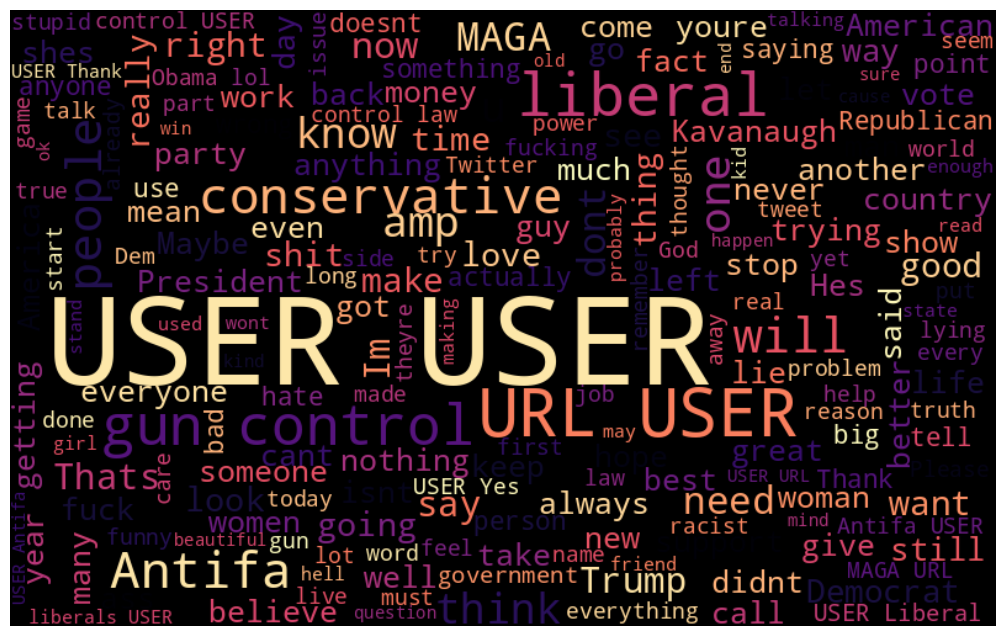

In [ ]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in tweet_df['tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, colormap='magma', height=500, random_state=RANDOM_SEED, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# drop the rows where at least one element is missing
tweet_df = tweet_df.dropna()

print(f'Number of entries: {len(tweet_df)}')

Number of entries: 13240


##DATA PREPROCESSING

As data preprocessing techniques, we learned following.
- Tokenisation
- Text normalisation (lower casing, stemming and lemmatisation)
- Stop word removal
- Punctuation removal

###Tokenisationn

In [ ]:
# Initialize TweetTokenizer
tweet_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

# Function to clean and tokenize a tweet
def tokenise_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'#(\w+)', lambda m: m.group(1).lower(), text)  # Process hashtags
    tokens = tweet_tokenizer.tokenize(text)  # Tokenize
    tokens = [token for token in tokens if token not in string.punctuation]
    return ' '.join(tokens)  # Merge tokens back into a sentence

# Apply preprocessing to the DataFrame
tweet_df['tokenised_tweet'] = tweet_df['tweet'].apply(tokenise_tweet)
test_df['tokenised_tweet'] = test_df['tweet'].apply(tokenise_tweet)

test_df.head()



,id,tweet,tokenised_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday is revered by conservatives ha...
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump 2ndamendment rnc ...
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting the news that she is s...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo to oppose the far-right i...


###Text normalisation

####Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

# Define a function for lemmatization
def wordNet_lemmatize_tweet(tweet):
    words = tweet.split()  # Split text into words
    lemmatized_words = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in words]  # Lemmatize each word
    return ' '.join(lemmatized_words)  # Join words back into a sentence

# Apply lemmatization to the tokenized tweets
tweet_df['wordNet_lemmatised_tweet'] = tweet_df['tokenised_tweet'].apply(wordNet_lemmatize_tweet)
test_df['wordNet_lemmatised_tweet'] = test_df['tokenised_tweet'].apply(wordNet_lemmatize_tweet)

test_df.head()

,id,tweet,tokenised_tweet,wordNet_lemmatised_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserver dumpnike declasfisa dem...
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday is revered by conservatives ha...,constitutionday be revere by conservatives hat...
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump 2ndamendment rnc ...,foxnews nra maga potus trump 2ndamendment rnc ...
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting the news that she is s...,watch boomer get the news that she be still up...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo to oppose the far-right i...,nopasaran unity demo to oppose the far-right i...


In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize_text(text):
    lemm = nlp(text)
    return ' '.join([token.lemma_ for token in lemm])

# Apply lemmatization
tweet_df['spacy_lemmatised_tweet'] = tweet_df['tokenised_tweet'].apply(spacy_lemmatize_text)
test_df['spacy_lemmatised_tweet'] = test_df['tokenised_tweet'].apply(spacy_lemmatize_text)

test_df.head()

,id,tweet,tokenised_tweet,wordNet_lemmatised_tweet,spacy_lemmatised_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserver dumpnike declasfisa dem...
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday is revered by conservatives ha...,constitutionday be revere by conservatives hat...,constitutionday be revere by conservative hate...
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump 2ndamendment rnc ...,foxnews nra maga potus trump 2ndamendment rnc ...,foxnew nra maga potus trump 2ndamendment rnc u...
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting the news that she is s...,watch boomer get the news that she be still up...,watch boomer get the news that she be still up...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo to oppose the far-right i...,nopasaran unity demo to oppose the far-right i...,nopasaran unity demo to oppose the far - right...


###Stemming

In [ ]:
porter_stemmer = PorterStemmer()

# Function for stemming using PorterStemmer
def stem_text_with_porter(text):
    tokens = text.split()  # Ensure text is split into words
    return ' '.join([porter_stemmer.stem(token) for token in tokens])

# Apply stemming
tweet_df['porter_stemmed_tweet'] = tweet_df['tokenised_tweet'].apply(stem_text_with_porter)
test_df['porter_stemmed_tweet'] = test_df['tokenised_tweet'].apply(stem_text_with_porter)

test_df.head()

,id,tweet,tokenised_tweet,wordNet_lemmatised_tweet,spacy_lemmatised_tweet,porter_stemmed_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserv dumpnik declasfisa democr...
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday is revered by conservatives ha...,constitutionday be revere by conservatives hat...,constitutionday be revere by conservative hate...,constitutionday is rever by conserv hate by pr...
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump 2ndamendment rnc ...,foxnews nra maga potus trump 2ndamendment rnc ...,foxnew nra maga potus trump 2ndamendment rnc u...,foxnew nra maga potu trump 2ndamend rnc usmc v...
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting the news that she is s...,watch boomer get the news that she be still up...,watch boomer get the news that she be still up...,watch boomer get the news that she is still up...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo to oppose the far-right i...,nopasaran unity demo to oppose the far-right i...,nopasaran unity demo to oppose the far - right...,nopasaran uniti demo to oppos the far-right in...


In [ ]:
# Initialize Snowball Stemmer for English
snowball_stemmer = SnowballStemmer("english")

# Function for stemming using SnowballStemmer
def stem_text_with_snowball(text):
    tokens = text.split()  # Ensure text is split into words
    return ' '.join([snowball_stemmer.stem(token) for token in tokens])

# Apply stemming
tweet_df['snowball_stemmed_tweet'] = tweet_df['tokenised_tweet'].apply(stem_text_with_snowball)
test_df['snowball_stemmed_tweet'] = test_df['tokenised_tweet'].apply(stem_text_with_snowball)

tweet_df.head()

,id,tweet,label,tokenised_tweet,wordNet_lemmatised_tweet,spacy_lemmatised_tweet,porter_stemmed_tweet,snowball_stemmed_tweet
0,86426,@USER She should ask a few native Americans wh...,UNT,she should ask a few native americans what the...,she should ask a few native americans what the...,she should ask a few native americans what the...,she should ask a few nativ american what their...,she should ask a few nativ american what their...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN,go home you ’ re drunk maga trump 2020 👊 🇺🇸 👊 url,go home you ’ re drink maga trump 2020 👊 🇺🇸 👊 url,go home you ' re drunk maga trump 2020 👊 🇺 🇸 👊...,go home you ’ re drunk maga trump 2020 👊 🇺🇸 👊 url,go home you ’ re drunk maga trump 2020 👊 🇺🇸 👊 url
2,16820,Amazon is investigating Chinese employees who ...,NOT,amazon is investigating chinese employees who ...,amazon be investigate chinese employees who be...,amazon be investigate chinese employee who be ...,amazon is investig chines employe who are sell...,amazon is investig chines employe who are sell...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT,someone should'vetaken this piece of shit to a...,someone should'vetaken this piece of shit to a...,someone should'vetaken this piece of shit to a...,someon should'vetaken thi piec of shit to a vo...,someon should'vetaken this piec of shit to a v...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,obama wanted liberals illegals to move into re...,obama want liberals illegals to move into red ...,obama want liberal illegal to move into red state,obama want liber illeg to move into red state,obama want liber illeg to move into red state


In [ ]:
# Initialize Lancaster Stemmer
lancaster_stemmer = LancasterStemmer()

# Function for stemming using LancasterStemmer
def stem_text_with_lancaster(text):
    tokens = text.split()  # Ensure text is split into words
    return ' '.join([lancaster_stemmer.stem(token) for token in tokens])

# Apply stemming
tweet_df['lancaster_stemmed_tweet'] = tweet_df['tokenised_tweet'].apply(stem_text_with_lancaster)
test_df['lancaster_stemmed_tweet'] = test_df['tokenised_tweet'].apply(stem_text_with_lancaster)

test_df.head()

,id,tweet,tokenised_tweet,wordNet_lemmatised_tweet,spacy_lemmatised_tweet,porter_stemmed_tweet,snowball_stemmed_tweet,lancaster_stemmed_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserver dumpnike declasfisa dem...,whoisq wherestheserv dumpnik declasfisa democr...,whoisq wherestheserv dumpnik declasfisa democr...,whoisq wherestheserv dumpnik declasfis democr ...
1,27014,"#ConstitutionDay is revered by Conservatives, ...",constitutionday is revered by conservatives ha...,constitutionday be revere by conservatives hat...,constitutionday be revere by conservative hate...,constitutionday is rever by conserv hate by pr...,constitutionday is rever by conserv hate by pr...,constitutionday is rev by conserv hat by progr...
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,foxnews nra maga potus trump 2ndamendment rnc ...,foxnews nra maga potus trump 2ndamendment rnc ...,foxnew nra maga potus trump 2ndamendment rnc u...,foxnew nra maga potu trump 2ndamend rnc usmc v...,foxnew nra maga potus trump 2ndamend rnc usmc ...,foxnew nra mag pot trump 2ndamendment rnc usmc...
3,13876,#Watching #Boomer getting the news that she is...,watching boomer getting the news that she is s...,watch boomer get the news that she be still up...,watch boomer get the news that she be still up...,watch boomer get the news that she is still up...,watch boomer get the news that she is still up...,watch boom get the new that she is stil up for...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,nopasaran unity demo to oppose the far-right i...,nopasaran unity demo to oppose the far-right i...,nopasaran unity demo to oppose the far - right...,nopasaran uniti demo to oppos the far-right in...,nopasaran uniti demo to oppos the far-right in...,nopas un demo to oppos the far-right in london...


In [ ]:
test_df.head()

,id,tweet,label,cleaned_tweet
0,92723,@USER @USER THERE ARE MORE JOBS AVAILABLE THAN...,NOT,user user jobs available people fill said never
1,27052,@USER Personally I prefer my anti-fascism in t...,NOT,user personally prefer anti fascism form non n...
2,41994,@USER Dems trying to clean up their sloppy #ka...,NOT,user dems trying clean sloppy
3,80267,@USER So the FBI is a hotbed of liberals and l...,NOT,user fbi hotbed liberals leftists brian dennehy
4,44698,#guncontrol #robbery #murder #Selfdense #Defen...,NOT,want gun control three armed home invaders try...


In [ ]:
test_df.head()

###Punctuation Removal

In [ ]:
# get English stopwords
# stop_words = set(stopwords.words('english'))

# Words to keep (convert to set)
# words_to_keep = {'against', 'not', 'no', 'nor', 'ain', 'aren', "aren't", 'couldn',
#     "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
#     'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'shouldn',
#     "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
#     'wouldn', "wouldn't", 'against'}

keep_words = {'not', 'no', 'never', 'none', 'she', 'you', 'youre', 'ur', 'yours', 'he', 'they', 'they', 'their'}

# Initialize with standard stop words
custom_stop = set(stopwords.words('english'))

# Remove critical words to keep
custom_stop = custom_stop - keep_words

print(custom_stop)  # Check the final list of stop words

{'am', 'any', 'in', "we'll", 'up', 'herself', 'ain', 'was', "we're", 'with', 're', 'mightn', 'between', 'while', 'down', "she's", 'that', 'such', "mightn't", "couldn't", "i'm", 'shouldn', 'all', 'theirs', "mustn't", 'if', 'ours', 'o', 'most', 'there', "needn't", 'don', 'until', 'through', "hasn't", 'what', 'were', "i've", 'it', 'because', 'some', "hadn't", "it's", 'at', 'these', 'we', 'by', 'out', 'other', "didn't", 'then', 'y', 'of', 've', 'again', "he's", 'when', 'here', 'who', 'before', 'hadn', 'me', 'shan', 'weren', 'after', "she'd", "doesn't", 'under', 'an', 'against', 'to', 'but', "they'll", "you'll", "aren't", 'nor', 'do', "it'd", 'this', 'those', "you've", 'been', "should've", "wasn't", 'being', 'my', 'needn', "they'd", "they've", 'wasn', 'and', "you're", 'more', 'about', 'himself', 'doesn', "she'll", 'during', 'which', 'too', 'them', 'why', 'having', 'mustn', 'same', 'only', 'very', 'its', 'your', 'ma', 'than', 'd', 'him', "he'd", 'does', 'now', 'both', 'm', 's', 'is', 'doing'

##FEATURE SELECTION

In [ ]:
stop_words = stopwords.words('english')

# use raw text
X_train_tweet, X_val_tweet, y_train, y_val = train_test_split(tweet_df['tweet'], tweet_df['label'], test_size=0.3, random_state=RANDOM_SEED, stratify=tweet_df['label'])
print(f'training data set size: {len(X_train_tweet)}')
print(f'validation data set size: {len(X_val_tweet)}')

# use tokenised text
X_train_tokenised_tweet, X_val_tokenised_tweet, y_train, y_val = train_test_split(tweet_df['tokenised_tweet'], tweet_df['label'], test_size=0.3, random_state=RANDOM_SEED, stratify=tweet_df['label'])
print(f'training data set size: {len(X_train_tokenised_tweet)}')
print(f'validation data set size: {len(X_val_tokenised_tweet)}')

# use lemmatised text
X_train_wordNet_lemmatised_tweet, X_val_wordNet_lemmatised_tweet, y_train, y_val = train_test_split(tweet_df['wordNet_lemmatised_tweet'], tweet_df['label'], test_size=0.3, random_state=RANDOM_SEED, stratify=tweet_df['label'])
print(f'training data set size: {len(X_train_wordNet_lemmatised_tweet)}')
print(f'validation data set size: {len(X_val_wordNet_lemmatised_tweet)}')

# use lemmatised text
X_train_spacy_lemmatised_tweet, X_val_spacy_lemmatised_tweet, y_train, y_val = train_test_split(tweet_df['spacy_lemmatised_tweet'], tweet_df['label'], test_size=0.3, random_state=RANDOM_SEED, stratify=tweet_df['label'])
print(f'training data set size: {len(X_train_spacy_lemmatised_tweet)}')
print(f'validation data set size: {len(X_val_spacy_lemmatised_tweet)}')

# use stemmised text
X_train_porter_stemmed_tweet, X_val_porter_stemmed_tweet, y_train, y_val = train_test_split(tweet_df['porter_stemmed_tweet'], tweet_df['label'], test_size=0.3, random_state=RANDOM_SEED, stratify=tweet_df['label'])
print(f'training data set size: {len(X_train_porter_stemmed_tweet)}')
print(f'validation data set size: {len(X_val_porter_stemmed_tweet)}')

# use stemmised text
X_train_snowball_stemmed_tweet, X_val_snowball_stemmed_tweet, y_train, y_val = train_test_split(tweet_df['snowball_stemmed_tweet'], tweet_df['label'], test_size=0.3, random_state=RANDOM_SEED, stratify=tweet_df['label'])
print(f'training data set size: {len(X_train_snowball_stemmed_tweet)}')
print(f'validation data set size: {len(X_val_snowball_stemmed_tweet)}')

# use stemmised text
X_train_lancaster_stemmed_tweet, X_val_lancaster_stemmed_tweet, y_train, y_val = train_test_split(tweet_df['lancaster_stemmed_tweet'], tweet_df['label'], test_size=0.3, random_state=RANDOM_SEED, stratify=tweet_df['label'])
print(f'training data set size: {len(X_train_lancaster_stemmed_tweet)}')
print(f'validation data set size: {len(X_val_lancaster_stemmed_tweet)}')

training data set size: 9268
validation data set size: 3972
training data set size: 9268
validation data set size: 3972
training data set size: 9268
validation data set size: 3972
training data set size: 9268
validation data set size: 3972
training data set size: 9268
validation data set size: 3972
training data set size: 9268
validation data set size: 3972
training data set size: 9268
validation data set size: 3972


##MODEL EVALUATION

In [ ]:
def evaluate(actuals, predictions, class_names):
  '''
  actuals: list of actual labels
  predictions: list of predicted labels
  class_names: list of classes used for the model/classification task
  '''
  # calculate accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

  # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()

##SVM

In [ ]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf

###SVM_M1

Accuracy: 0.7114803625377644


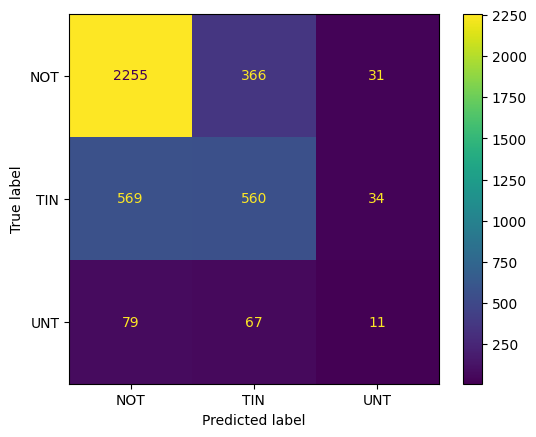

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

m1 = get_svm_predictions(X_train, X_val, y_train, y_val)

###SVM_M2

Accuracy: 0.7421953675730111


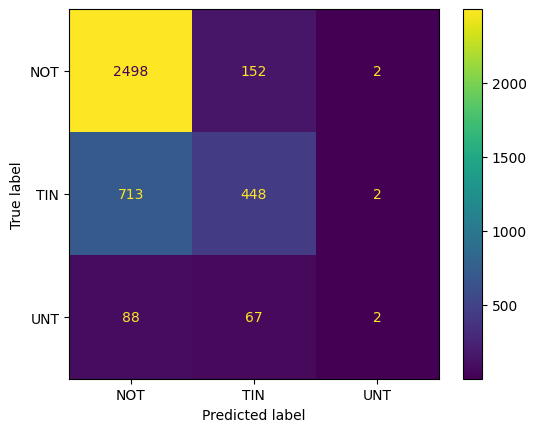

In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

m2 = get_svm_predictions(X_train, X_val, y_train, y_val)

###SVM_M3

Accuracy: 0.7464753272910373


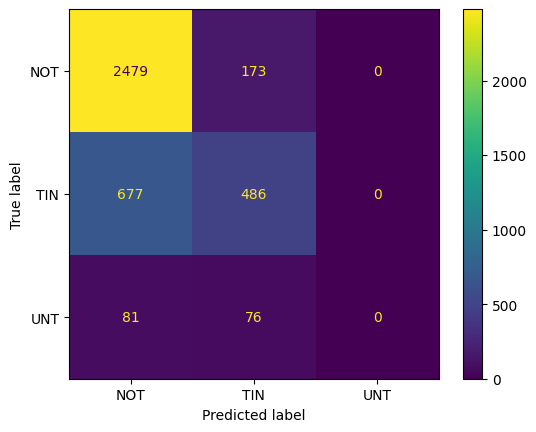

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_tokenised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_tweet)
X_val = vectorizer.transform(X_val_tokenised_tweet)

m3 = get_svm_predictions(X_train, X_val, y_train, y_val)

###SVM_M4

Accuracy: 0.7540281973816717


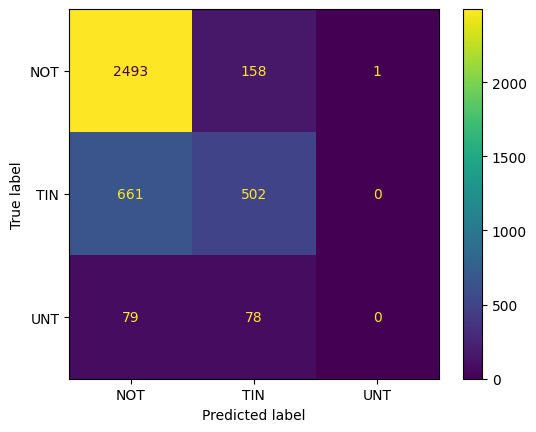

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_wordNet_lemmatised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_wordNet_lemmatised_tweet)
X_val = vectorizer.transform(X_val_wordNet_lemmatised_tweet)

m4 = get_svm_predictions(X_train, X_val, y_train, y_val)

###SVM_M5

Accuracy: 0.7482376636455186


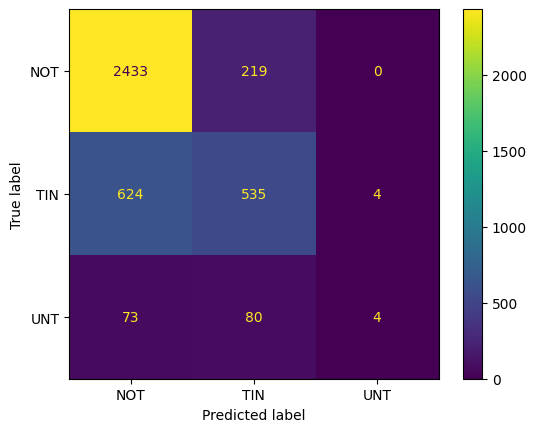

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
vectorizer.fit(X_train_spacy_lemmatised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_spacy_lemmatised_tweet)
X_val = vectorizer.transform(X_val_spacy_lemmatised_tweet)

m5 = get_svm_predictions(X_train, X_val, y_train, y_val)

###SVM_M6

Accuracy: 0.7444612286002014


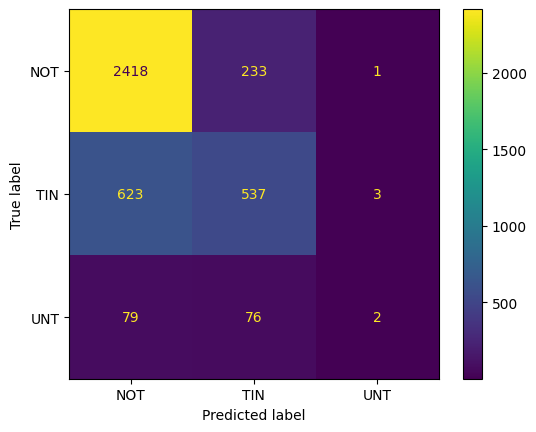

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
# vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_porter_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_porter_stemmed_tweet)
X_val = vectorizer.transform(X_val_porter_stemmed_tweet)

m6 = get_svm_predictions(X_train, X_val, y_train, y_val)

###SVM_M7

Accuracy: 0.7469788519637462


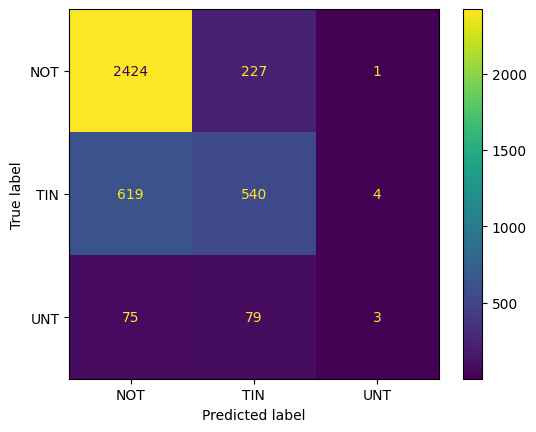

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
vectorizer.fit(X_train_snowball_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_snowball_stemmed_tweet)
X_val = vectorizer.transform(X_val_snowball_stemmed_tweet)

m7 = get_svm_predictions(X_train, X_val, y_train, y_val)

###SVM_M8

Accuracy: 0.7369083585095669


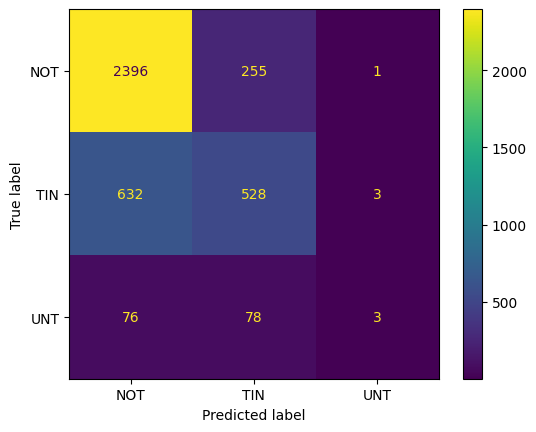

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop_words))
vectorizer.fit(X_train_lancaster_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lancaster_stemmed_tweet)
X_val = vectorizer.transform(X_val_lancaster_stemmed_tweet)

m8 = get_svm_predictions(X_train, X_val, y_train, y_val)

##LOGISTIC REGRESSIONN

In [ ]:
# method to train and predict using SVM classifier
def get_lr_predictions(X_train, X_val, y_train, y_val):
  # build model
  lr = LogisticRegression(random_state=RANDOM_SEED)
  lr.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = lr.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, lr.classes_)

  return lr

###LR_M1

Accuracy: 0.7311178247734139


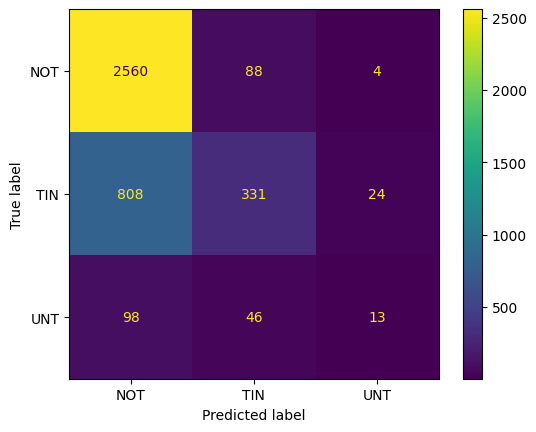

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

m1 = get_lr_predictions(X_train, X_val, y_train, y_val)

##LR_M2

Accuracy: 0.7182779456193353


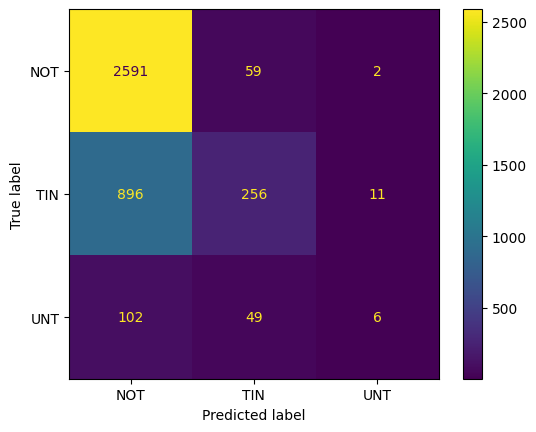

In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

m2 = get_lr_predictions(X_train, X_val, y_train, y_val)

##LR_M3

Accuracy: 0.7406847935548841


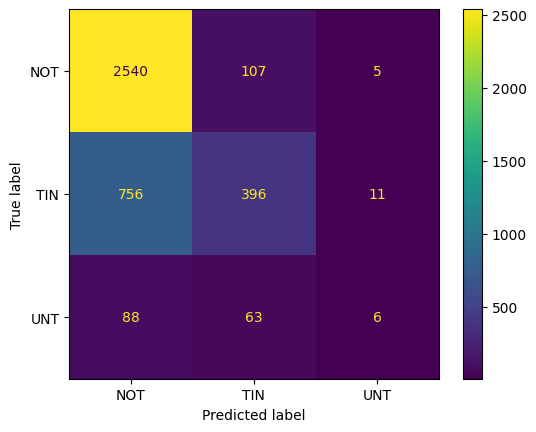

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_tokenised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_tweet)
X_val = vectorizer.transform(X_val_tokenised_tweet)

m3 = get_lr_predictions(X_train, X_val, y_train, y_val)

##LR_M4

Accuracy: 0.74269889224572


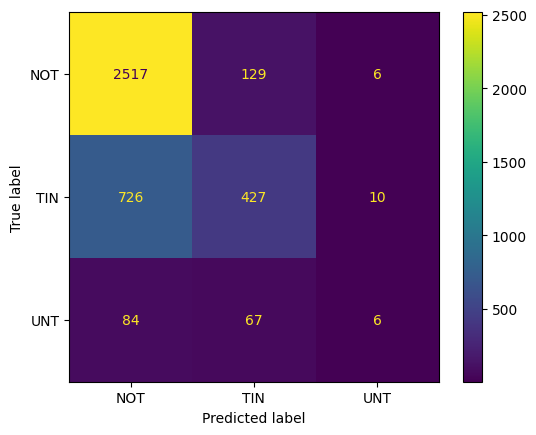

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_wordNet_lemmatised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_wordNet_lemmatised_tweet)
X_val = vectorizer.transform(X_val_wordNet_lemmatised_tweet)

m4 = get_lr_predictions(X_train, X_val, y_train, y_val)

##LR_M5

Accuracy: 0.7369083585095669


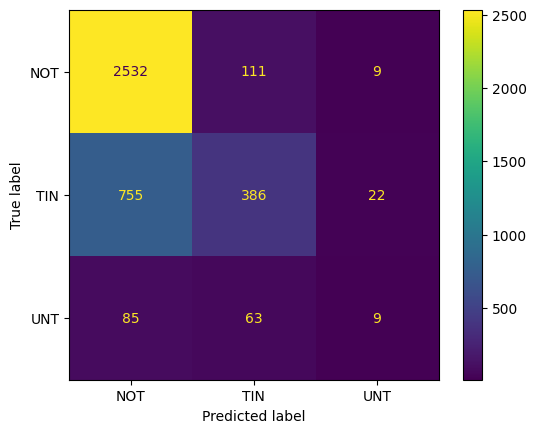

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
vectorizer.fit(X_train_spacy_lemmatised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_spacy_lemmatised_tweet)
X_val = vectorizer.transform(X_val_spacy_lemmatised_tweet)

m5 = get_lr_predictions(X_train, X_val, y_train, y_val)

##LR_M6

Accuracy: 0.7321248741188319


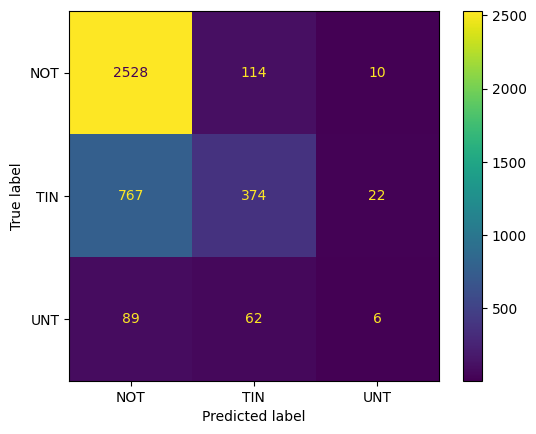

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
# vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_porter_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_porter_stemmed_tweet)
X_val = vectorizer.transform(X_val_porter_stemmed_tweet)

m6 = get_lr_predictions(X_train, X_val, y_train, y_val)

##LR_M7

Accuracy: 0.729607250755287


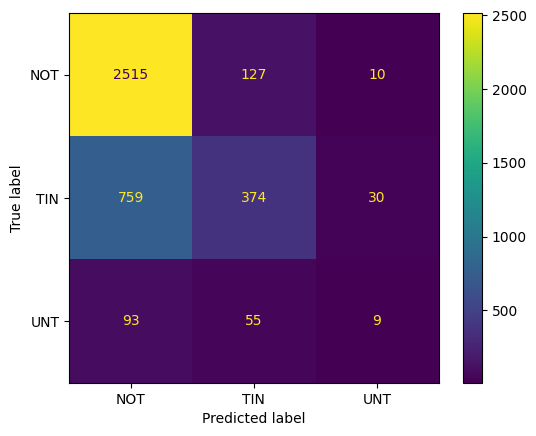

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
vectorizer.fit(X_train_snowball_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_snowball_stemmed_tweet)
X_val = vectorizer.transform(X_val_snowball_stemmed_tweet)

m7 = get_lr_predictions(X_train, X_val, y_train, y_val)

##LR_M8

Accuracy: 0.7293554884189325


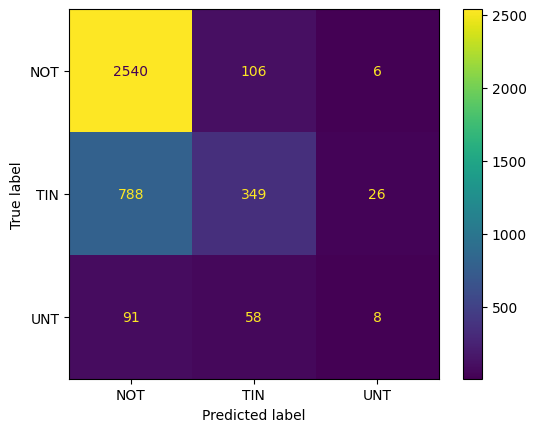

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop_words))
vectorizer.fit(X_train_lancaster_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lancaster_stemmed_tweet)
X_val = vectorizer.transform(X_val_lancaster_stemmed_tweet)

m8 = get_lr_predictions(X_train, X_val, y_train, y_val)

##RANDOM FOREST

In [ ]:
# method to train and predict using Random Forest
def get_rf_predictions(X_train, X_val, y_train, y_val):
  # build model
  rf = RandomForestClassifier(random_state=RANDOM_SEED)
  rf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = rf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, rf.classes_)

  return rf

###RF_M1

Accuracy: 0.7311178247734139


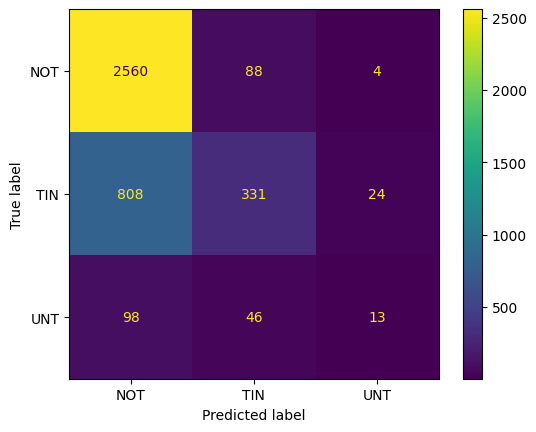

RandomForestClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

get_rf_predictions(X_train, X_val, y_train, y_val)

###RF_M2

Accuracy: 0.7182779456193353


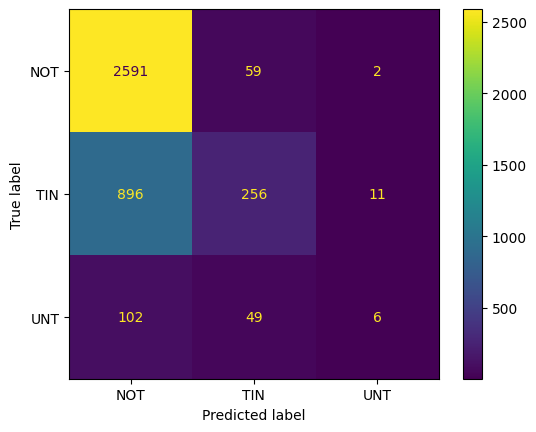

RandomForestClassifier(random_state=100)

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

get_rf_predictions(X_train, X_val, y_train, y_val)

###RF_M3

Accuracy: 0.7406847935548841


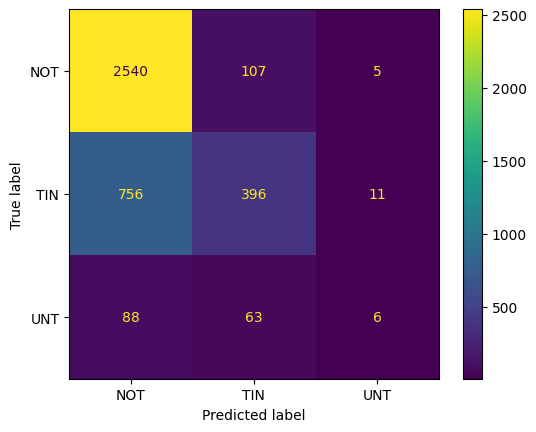

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_tokenised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_tweet)
X_val = vectorizer.transform(X_val_tokenised_tweet)

m3 = get_rf_predictions(X_train, X_val, y_train, y_val)

###RF_M4

Accuracy: 0.74269889224572


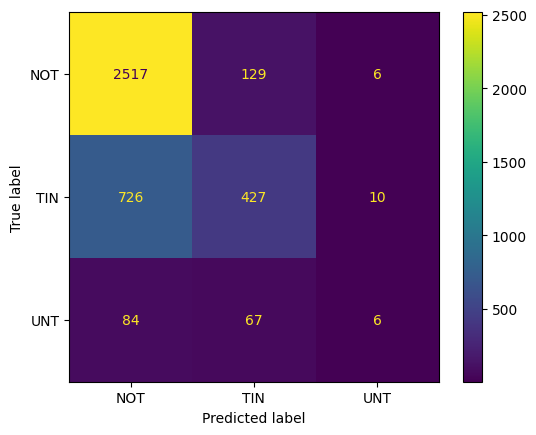

RandomForestClassifier(random_state=100)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_wordNet_lemmatised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_wordNet_lemmatised_tweet)
X_val = vectorizer.transform(X_val_wordNet_lemmatised_tweet)

get_rf_predictions(X_train, X_val, y_train, y_val)

###RF_M5

Accuracy: 0.7492447129909365


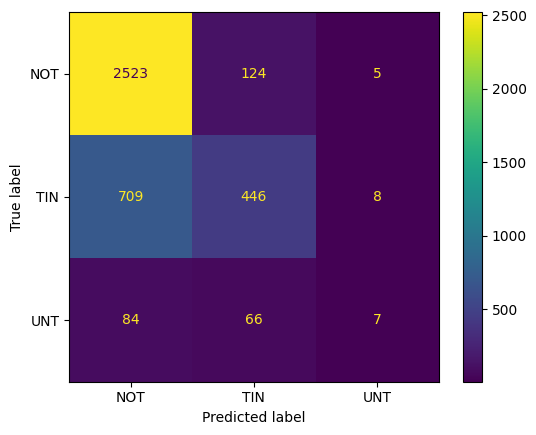

RandomForestClassifier(random_state=100)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_spacy_lemmatised_tweet)

# Convert train and validation text data to numeric vectors
X_train = vectorizer.transform(X_train_spacy_lemmatised_tweet)
X_val = vectorizer.transform(X_val_spacy_lemmatised_tweet)

get_rf_predictions(X_train, X_val, y_train, y_val)

###RF_M6

Accuracy: 0.7434541792547835


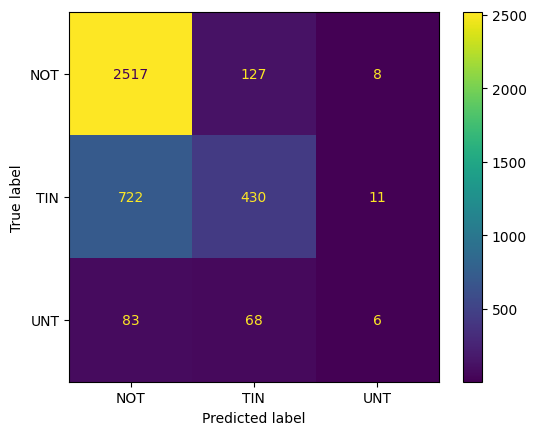

RandomForestClassifier(random_state=100)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
# vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_porter_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_porter_stemmed_tweet)
X_val = vectorizer.transform(X_val_porter_stemmed_tweet)

get_rf_predictions(X_train, X_val, y_train, y_val)

###RF_M7

Accuracy: 0.7497482376636455


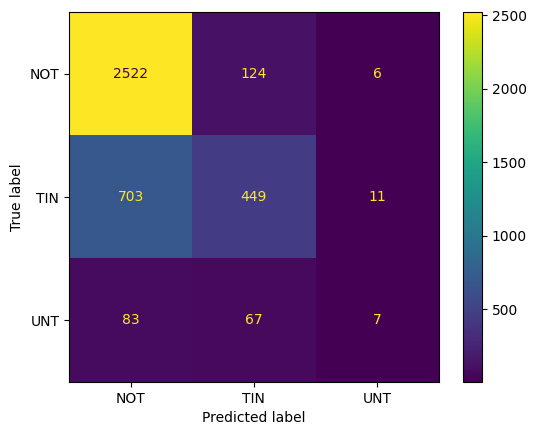

RandomForestClassifier(random_state=100)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_snowball_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_snowball_stemmed_tweet)
X_val = vectorizer.transform(X_val_snowball_stemmed_tweet)

get_rf_predictions(X_train, X_val, y_train, y_val)

###RF_M8

Accuracy: 0.7391742195367573


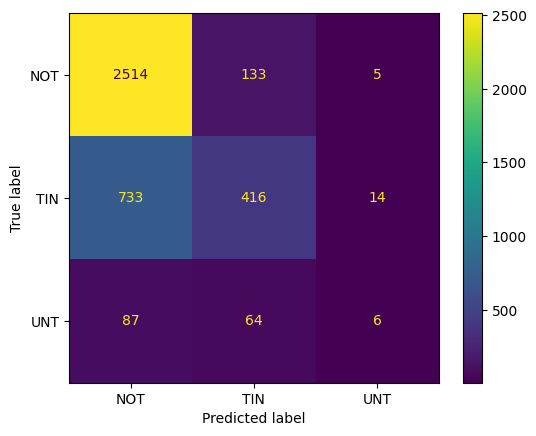

RandomForestClassifier(random_state=100)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_lancaster_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lancaster_stemmed_tweet)
X_val = vectorizer.transform(X_val_lancaster_stemmed_tweet)

get_rf_predictions(X_train, X_val, y_train, y_val)

##EXTRA TREES CLASSIFIER

In [ ]:
# method to train and predict using Extra Trees
def get_et_predictions(X_train, X_val, y_train, y_val):
  # build model
  # clf = ExtraTreesClassifier(random_state=RANDOM_SEED, n_estimators=200, max_depth=None)
  et = ExtraTreesClassifier(random_state=RANDOM_SEED)
  et.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = et.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, et.classes_)

  return et

###ET_M1

Accuracy: 0.7469788519637462


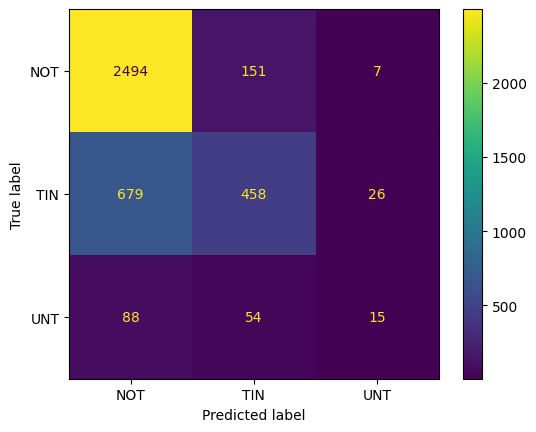

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###ET_M2

Accuracy: 0.7298590130916415


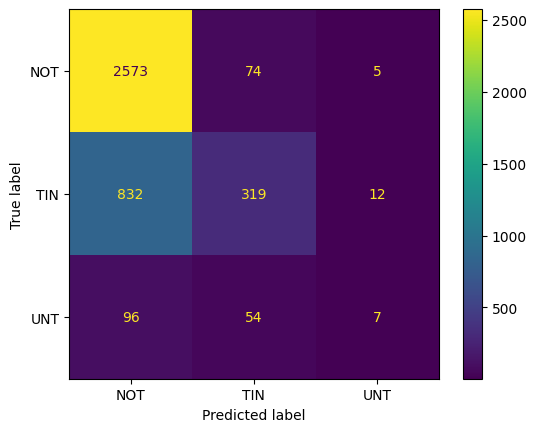

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###ET_M3

Accuracy: 0.7447129909365559


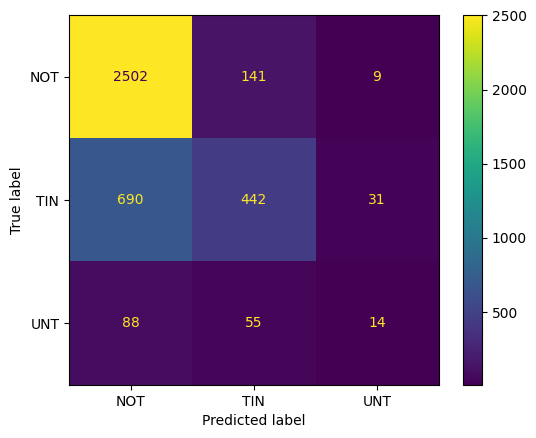

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tokenised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tokenised_tweet)
X_val = vectorizer.transform(X_val_tokenised_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###ET_M4

Accuracy: 0.7469788519637462


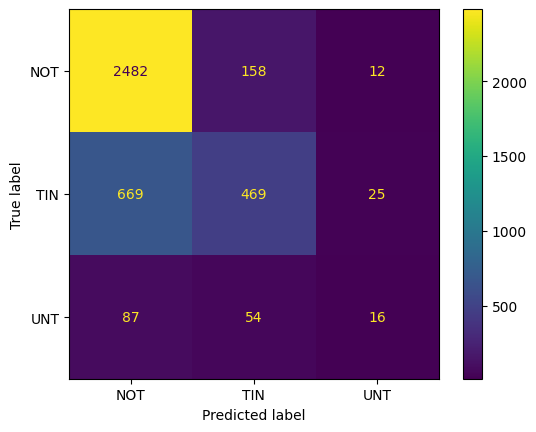

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_wordNet_lemmatised_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_wordNet_lemmatised_tweet)
X_val = vectorizer.transform(X_val_wordNet_lemmatised_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###ET_M5

Accuracy: 0.75


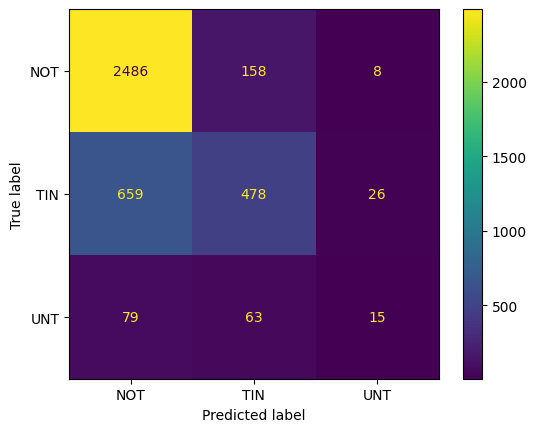

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train_spacy_lemmatised_tweet)

# Convert train and validation text data to numeric vectors
X_train = vectorizer.transform(X_train_spacy_lemmatised_tweet)
X_val = vectorizer.transform(X_val_spacy_lemmatised_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###ET_M6

Accuracy: 0.74269889224572


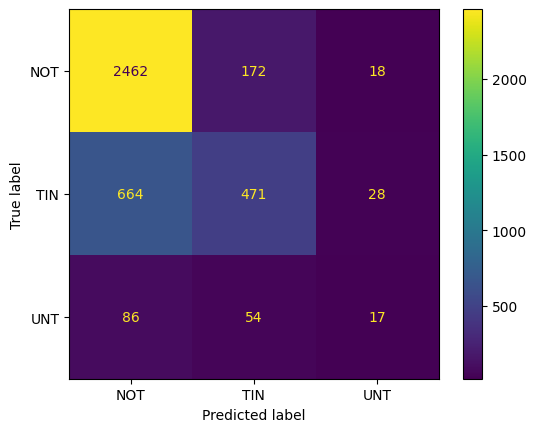

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
# vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_porter_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_porter_stemmed_tweet)
X_val = vectorizer.transform(X_val_porter_stemmed_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###ET_M7

Accuracy: 0.7477341389728097


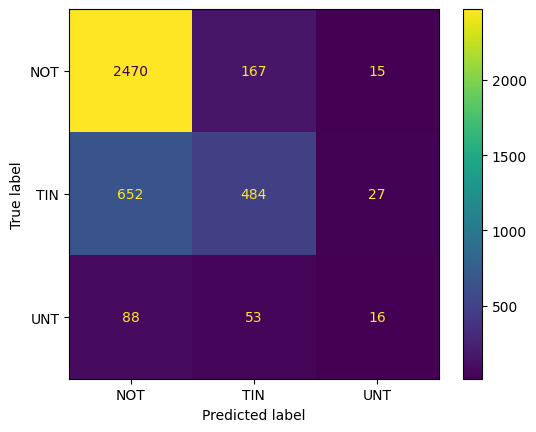

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_snowball_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_snowball_stemmed_tweet)
X_val = vectorizer.transform(X_val_snowball_stemmed_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###ET_M8

Accuracy: 0.7401812688821753


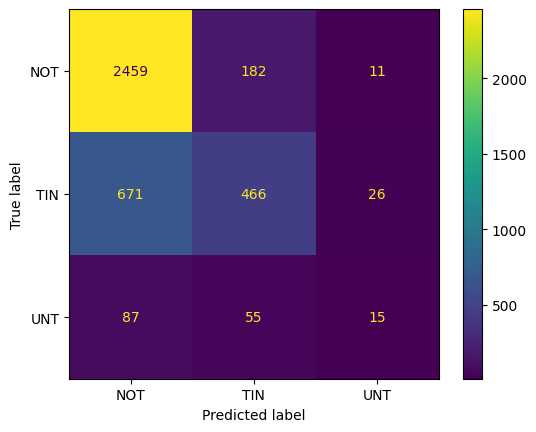

ExtraTreesClassifier(random_state=100)

In [ ]:
vectorizer = CountVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lancaster_stemmed_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_lancaster_stemmed_tweet)
X_val = vectorizer.transform(X_val_lancaster_stemmed_tweet)

get_et_predictions(X_train, X_val, y_train, y_val)

###APPLYING SMOTE TO HANDLE IMBALANCED DATA

###SVM_M10 -> HANDLING DATA IMBALANCE

In [ ]:
from collections import Counter
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
# vectorizer = CountVectorizer()

#COMBINED TRAIN AND TEST.  This can also be done with a pipeline
combined_text = pd.concat([tweet_df['spacy_lemmatised_tweet'], test_df['spacy_lemmatised_tweet']], axis=0)
vectorizer.fit(combined_text)
X_tfidf = vectorizer.fit_transform(tweet_df['spacy_lemmatised_tweet'])  # Convert to numerical features
# X_test_tfidf = vectorizer.transform(test_df['spacy_lemmatised_tweet'])  # Convert to numerical features

y = tweet_df['label']  # Target variable
# y_test = test_df['label']  # Target variable

# Apply SMOTE BEFORE splitting data
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Print class distributions before and after resampling
print(f"Original class distribution: {dict(Counter(y))}")
print(f"Resampled class distribution: {dict(Counter(y_resampled))}")

# Split the balanced dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)

print(f"Training dataset size: {X_train.shape[0]}")
print(f"Validation dataset size: {X_val.shape[0]}")

Original class distribution: {'UNT': 524, 'TIN': 3876, 'NOT': 8840}
Resampled class distribution: {'UNT': 8840, 'TIN': 8840, 'NOT': 8840}
Training dataset size: 18564
Validation dataset size: 7956


SVM Accuracy: 0.8614881850175968

Classification Report:
               precision    recall  f1-score   support

         NOT       0.85      0.73      0.78      2704
         TIN       0.76      0.86      0.81      2617
         UNT       0.99      1.00      0.99      2635

    accuracy                           0.86      7956
   macro avg       0.87      0.86      0.86      7956
weighted avg       0.87      0.86      0.86      7956



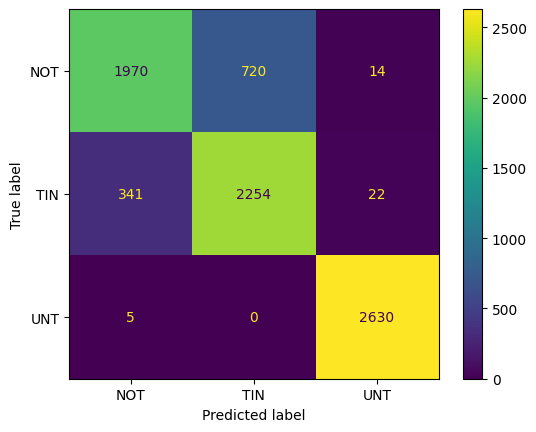

In [ ]:
clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_val)

# Evaluate model
from sklearn.metrics import accuracy_score, classification_report
print(f"SVM Accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()


###LR_M10 -> HANDLING DATA IMBALANCE

In [ ]:
from collections import Counter
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
# vectorizer = CountVectorizer()

#COMBINED TRAIN AND TEST.  This can also be done with a pipeline
combined_text = pd.concat([tweet_df['spacy_lemmatised_tweet'], test_df['spacy_lemmatised_tweet']], axis=0)
vectorizer.fit(combined_text)
X_tfidf = vectorizer.fit_transform(tweet_df['spacy_lemmatised_tweet'])  # Convert to numerical features
# X_test_tfidf = vectorizer.transform(test_df['spacy_lemmatised_tweet'])  # Convert to numerical features

y = tweet_df['label']  # Target variable
# y_test = test_df['label']  # Target variable

# Apply SMOTE BEFORE splitting data
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Print class distributions before and after resampling
print(f"Original class distribution: {dict(Counter(y))}")
print(f"Resampled class distribution: {dict(Counter(y_resampled))}")

# Split the balanced dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)

print(f"Training dataset size: {X_train.shape[0]}")
print(f"Validation dataset size: {X_val.shape[0]}")

Original class distribution: {'UNT': 524, 'TIN': 3876, 'NOT': 8840}
Resampled class distribution: {'UNT': 8840, 'TIN': 8840, 'NOT': 8840}
Training dataset size: 18564
Validation dataset size: 7956


SVM Accuracy: 0.8573403720462544

Classification Report:
               precision    recall  f1-score   support

         NOT       0.84      0.74      0.79      2704
         TIN       0.76      0.84      0.80      2617
         UNT       0.97      1.00      0.98      2635

    accuracy                           0.86      7956
   macro avg       0.86      0.86      0.86      7956
weighted avg       0.86      0.86      0.86      7956



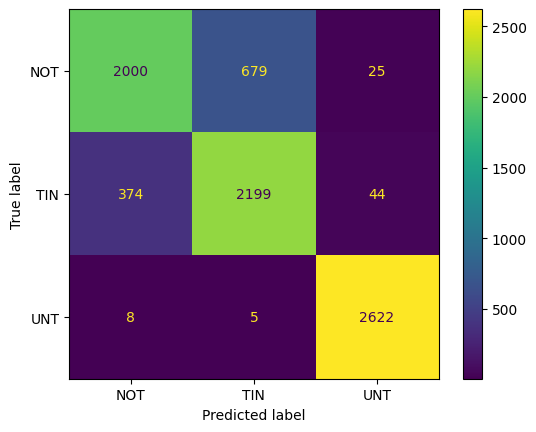

In [ ]:
clf = LogisticRegression(random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_val)

# Evaluate model
from sklearn.metrics import accuracy_score, classification_report
print(f"SVM Accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

###RF_M10 -> HANDLING DATA IMBALANCE

In [ ]:
from collections import Counter
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
# vectorizer = CountVectorizer()

#COMBINED TRAIN AND TEST.  This can also be done with a pipeline
combined_text = pd.concat([tweet_df['spacy_lemmatised_tweet'], test_df['spacy_lemmatised_tweet']], axis=0)
vectorizer.fit(combined_text)
X_tfidf = vectorizer.fit_transform(tweet_df['spacy_lemmatised_tweet'])  # Convert to numerical features
# X_test_tfidf = vectorizer.transform(test_df['cleaned_tweet'])  # Convert to numerical features

y = tweet_df['label']  # Target variable
# y_test = test_df['label']  # Target variable

# Apply SMOTE BEFORE splitting data
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Print class distributions before and after resampling
print(f"Original class distribution: {dict(Counter(y))}")
print(f"Resampled class distribution: {dict(Counter(y_resampled))}")

# Split the balanced dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)

print(f"Training dataset size: {X_train.shape[0]}")
print(f"Validation dataset size: {X_val.shape[0]}")

Original class distribution: {'UNT': 524, 'TIN': 3876, 'NOT': 8840}
Resampled class distribution: {'UNT': 8840, 'TIN': 8840, 'NOT': 8840}
Training dataset size: 18564
Validation dataset size: 7956


RandomForestClassifier Accuracy: 0.8883861236802413

Classification Report:
               precision    recall  f1-score   support

         NOT       0.82      0.88      0.85      2704
         TIN       0.86      0.81      0.83      2617
         UNT       0.99      0.98      0.99      2635

    accuracy                           0.89      7956
   macro avg       0.89      0.89      0.89      7956
weighted avg       0.89      0.89      0.89      7956



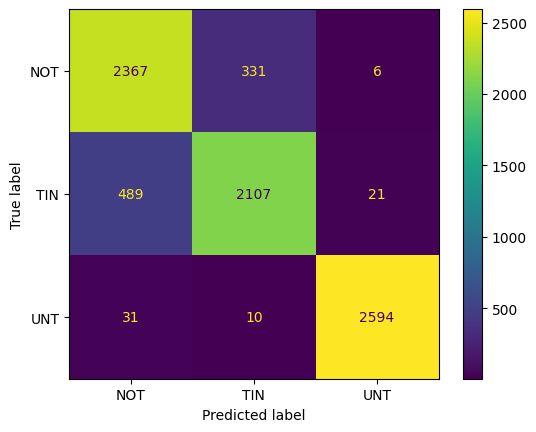

In [ ]:
clf = RandomForestClassifier(random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_val)

# Evaluate model
from sklearn.metrics import accuracy_score, classification_report
print(f"RandomForestClassifier Accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

###ET_M10 -> HANDLING DATA IMBALANCE

In [ ]:
from collections import Counter
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
# vectorizer = CountVectorizer()

#COMBINED TRAIN AND TEST.  This can also be done with a pipeline
combined_text = pd.concat([tweet_df['spacy_lemmatised_tweet'], test_df['spacy_lemmatised_tweet']], axis=0)
vectorizer.fit(combined_text)
X_tfidf = vectorizer.fit_transform(tweet_df['spacy_lemmatised_tweet'])  # Convert to numerical features
# X_test_tfidf = vectorizer.transform(test_df['spacy_lemmatised_tweet'])  # Convert to numerical features

y = tweet_df['label']  # Target variable
# y_test = test_df['label']  # Target variable

# Apply SMOTE BEFORE splitting data
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Print class distributions before and after resampling
print(f"Original class distribution: {dict(Counter(y))}")
print(f"Resampled class distribution: {dict(Counter(y_resampled))}")

# Split the balanced dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)

print(f"Training dataset size: {X_train.shape[0]}")
print(f"Validation dataset size: {X_val.shape[0]}")

Original class distribution: {'UNT': 524, 'TIN': 3876, 'NOT': 8840}
Resampled class distribution: {'UNT': 8840, 'TIN': 8840, 'NOT': 8840}
Training dataset size: 18564
Validation dataset size: 7956


ExtraTreesClassifier Accuracy: 0.910507792860734

Classification Report:
               precision    recall  f1-score   support

         NOT       0.83      0.93      0.88      2704
         TIN       0.92      0.81      0.86      2617
         UNT       0.99      0.99      0.99      2635

    accuracy                           0.91      7956
   macro avg       0.91      0.91      0.91      7956
weighted avg       0.91      0.91      0.91      7956



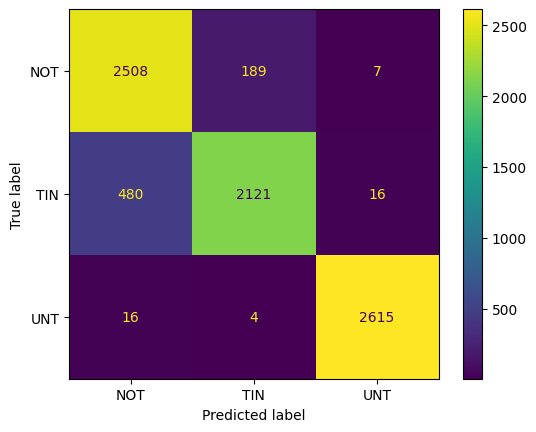

In [ ]:

clf = ExtraTreesClassifier(random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_val)

# Evaluate model
from sklearn.metrics import accuracy_score, classification_report
print(f"ExtraTreesClassifier Accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

<ipython-input-311-c0114a69fb15>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), ax=axes[0], palette=palette)
<ipython-input-311-c0114a69fb15>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), ax=axes[1], palette=palette)


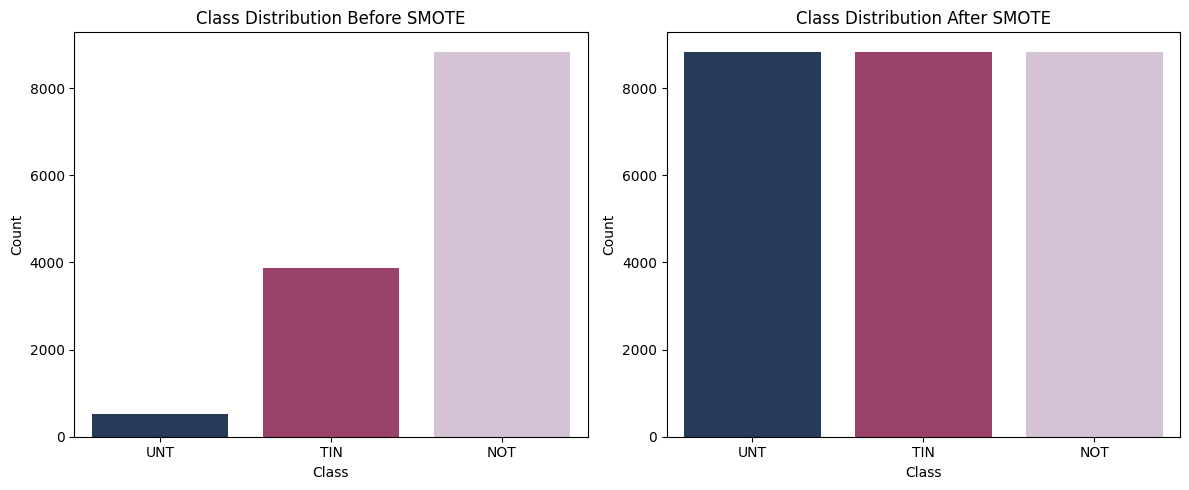

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE

# Original class distribution
y = tweet_df['label']
original_counts = Counter(y)

# Apply SMOTE
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(tweet_df.drop(columns=['label']), y)
resampled_counts = Counter(y_resampled)

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()), ax=axes[0], palette=palette)
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), ax=axes[1], palette=palette)
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


##PREDICTING TEST DATA

In [ ]:
X_test = vectorizer.transform(test_df['spacy_lemmatised_tweet'])
# make predictions using the best model
predictions = clf.predict(X_test)

# add predictions to the ‘prediction’ column
test_df['prediction'] = predictions

# Save only 'id' and 'prediction' columns
test_df[['id', 'prediction']].to_csv('/content/test-predictions.csv', index=False)

##MultinomialNB

In [ ]:
# method to train and predict using Decision Tree
def get_mnb_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = MultinomialNB()
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf

Accuracy: 0.7892156862745098


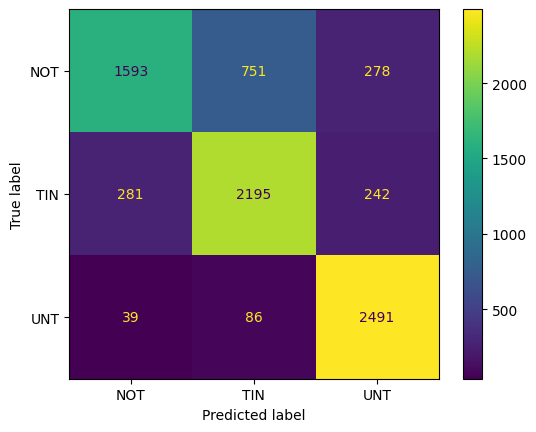

In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

m4 = get_mnb_predictions(X_train, X_val, y_train, y_val)

##XGBCLASSIFIER

In [ ]:
# method to train and predict using Extra Trees
def get_xgb_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels into numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

Accuracy: 0.8167420814479638


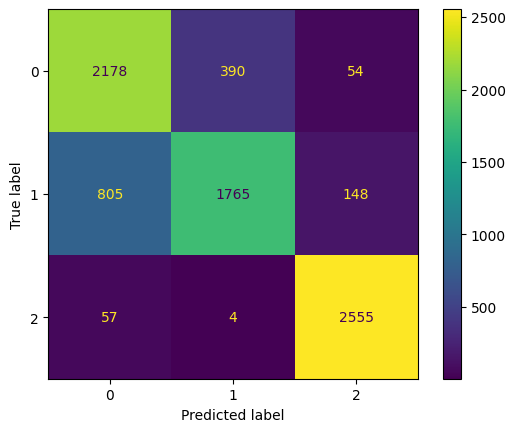

In [ ]:
vectorizer = TfidfVectorizer()  # default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_tweet)

# convert train and test text data to numeric vectors
X_train = vectorizer.transform(X_train_tweet)
X_val = vectorizer.transform(X_val_tweet)

m4 = get_xgb_predictions(X_train, X_val, y_train_encoded, y_val_encoded)